In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.autograd as autograd
import torch.optim as optim
from torch.optim import Adam
#!pip install torchviz
from torchviz import make_dot

from collections import Counter
import numpy as np

import os

import matplotlib.pyplot as plt
#!pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=True)

print("CUDA available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("PyTorch version: ", torch.__version__ )

CUDA available:  True
PyTorch version:  2.2.1+cu121


Total Number of Images for each Class:
    Class 0 (No Breast Cancer): 199287
    Class 1 (Breast Cancer present): 79634
Test size: 69730


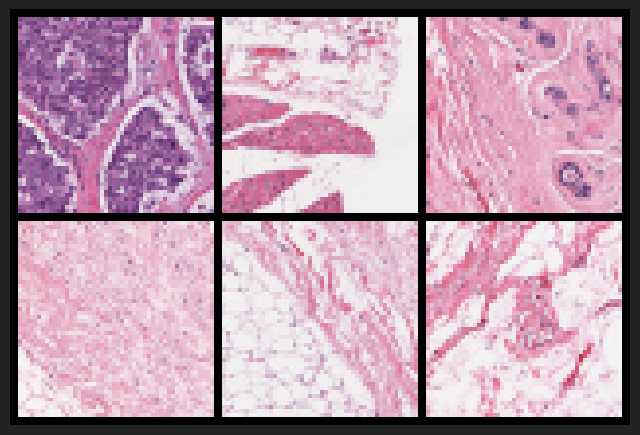

tensor([  7, 181, 147,  71, 181, 185])


In [14]:
# Define the path to the dataset
image_folders = "./DataSet/archive"

# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor()
])

# Load images into a list of datasets
images = []
for file in os.listdir(image_folders):
    try:
        images.append(ImageFolder(os.path.join(image_folders, file), transform=transform))
    except Exception as e:
        print(f"Error loading {file}: {e}")

# Concatenate all the datasets into one
datasets = torch.utils.data.ConcatDataset(images)

# Count the total number of images for each class
i = 0
for dataset in datasets.datasets:
    if i == 0:
        result = Counter(dataset.targets)
        i += 1
    else:
        result += Counter(dataset.targets)

result = dict(result)
print("""Total Number of Images for each Class:
    Class 0 (No Breast Cancer): {}
    Class 1 (Breast Cancer present): {}""".format(result[0], result[1]))

# Set random seed for reproducibility
random_seed = 1979
torch.manual_seed(random_seed)

# Determine the sizes of the training and testing sets
test_size = int(0.25 * (result[0] + result[1]))
print(f"Test size: {test_size}")
train_size = len(datasets) - test_size

# Split the datasets into training and testing sets
train_dataset, test_dataset = torch.utils.data.random_split(datasets, [train_size, test_size])

# Create data loaders for the training and testing sets
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Function to display images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:6], nrow=3))

# Show labels
print(labels[:6])

In [16]:
class BasicCNNNet(nn.Module):
  def __init__(self):
    super(BasicCNNNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
    self.conv3 = nn.Conv2d(128, 256, kernel_size=3)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(4096, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 1)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = x.view(-1, self.flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    x = F.log_softmax(x)
    return x

  def flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
      num_features *= s
    return num_features

net = BasicCNNNet()
net = net.to(device)

In [17]:
# Create a dummy input tensor with the correct size (batch_size, channels, height, width)
dummy_input = torch.randn(1, 3, 50, 50).to(device)

# Perform a forward pass to visualize the computation graph
output = net(dummy_input)

# Use torchviz to visualize the computation graph
dot = make_dot(output, params=dict(net.named_parameters()))
dot.format = 'png'
dot.render('BasicCNNNet')

/tmp/ipykernel_9907/2514310658.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

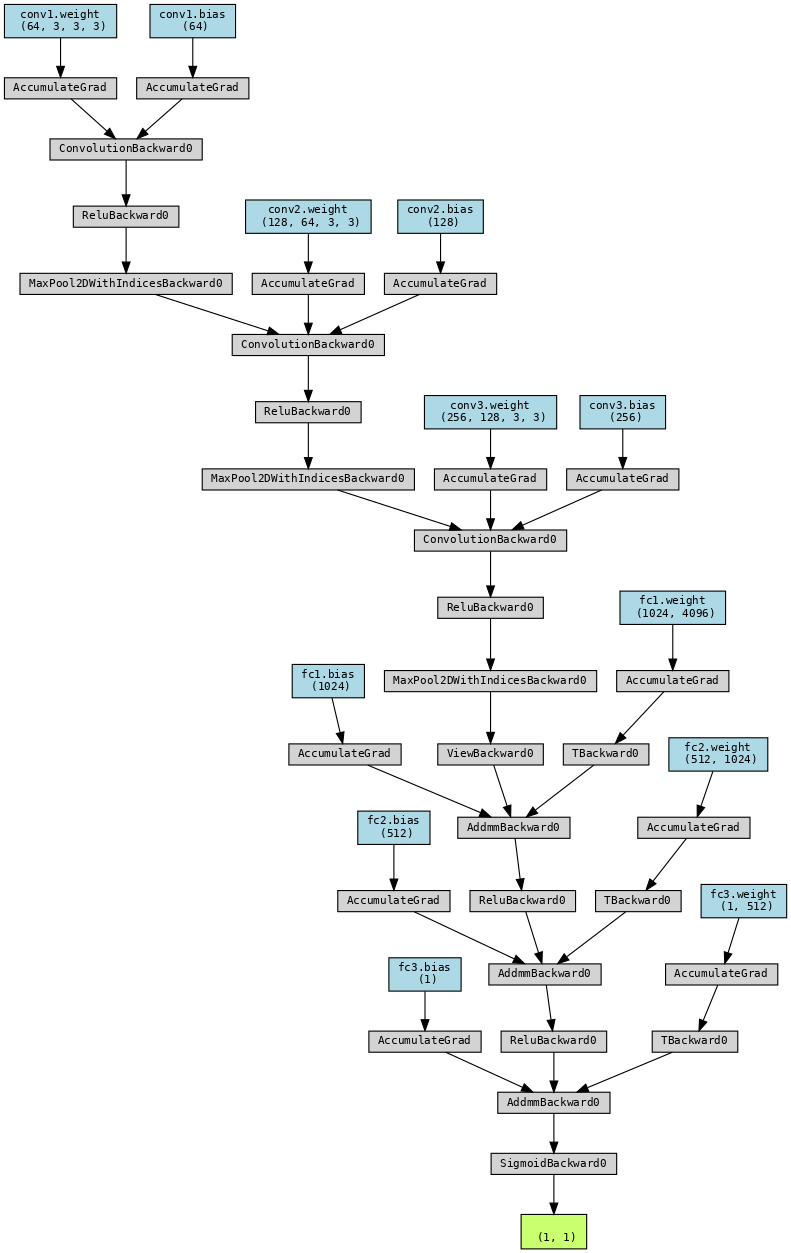

In [21]:
import os
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.utils.data
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchviz import make_dot
from IPython.display import Image, display

# Define the CNN model
class BasicCNNNet(nn.Module):
    def __init__(self):
        super(BasicCNNNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Dummy input to infer the size of the output from conv layers
        self._to_linear = None
        self._dummy_input()

        self.fc1 = nn.Linear(self._to_linear, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 1)

    def _dummy_input(self):
        x = torch.randn(1, 3, 50, 50)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        self._to_linear = x.view(-1).size(0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = torch.sigmoid(x)  # Use sigmoid for binary classification
        return x

# Initialize the model and move it to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = BasicCNNNet().to(device)

# Create a dummy input tensor with the correct size (batch_size, channels, height, width)
dummy_input = torch.randn(1, 3, 50, 50).to(device)

# Perform a forward pass to visualize the computation graph
output = net(dummy_input)

# Use torchviz to visualize the computation graph
dot = make_dot(output, params=dict(net.named_parameters()))
dot.format = 'png'
dot.render('BasicCNNNet')

# Display the image in the notebook
display(Image(filename='BasicCNNNet.png'))


In [1]:
import os
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.utils.data
import matplotlib.pyplot as plt
import numpy as np
from torchviz import make_dot
from IPython.display import Image, display
from tqdm import tqdm

# Set the CUDA_LAUNCH_BLOCKING environment variable
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Define the path to the dataset
image_folders = "./DataSet/archive"

# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor()
])

# Load images into a list of datasets
images = []
for file in os.listdir(image_folders):
    try:
        images.append(ImageFolder(os.path.join(image_folders, file), transform=transform))
    except Exception as e:
        print(f"Error loading {file}: {e}")

# Concatenate all the datasets into one
datasets = torch.utils.data.ConcatDataset(images)

# Ensure target labels are binary and of type Float
def convert_labels_to_binary(targets):
    targets = np.array(targets)
    targets = (targets == 1).astype(np.float32)  # Ensure labels are binary (0 or 1) and float32
    return torch.tensor(targets)

# Convert all dataset targets to binary
for dataset in datasets.datasets:
    dataset.targets = convert_labels_to_binary(dataset.targets)

# Count the total number of images for each class
i = 0
for dataset in datasets.datasets:
    if i == 0:
        result = Counter(dataset.targets.numpy())
        i += 1
    else:
        result += Counter(dataset.targets.numpy())

result = dict(result)
print("""Total Number of Images for each Class:
    Class 0 (No Breast Cancer): {}
    Class 1 (Breast Cancer present): {}""".format(result[0.0], result[1.0]))

# Set random seed for reproducibility
random_seed = 1979

# Reset CUDA device
torch.cuda.empty_cache()

# Set the manual seed
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

# Determine the sizes of the training and testing sets
test_size = int(0.25 * (result[0.0] + result[1.0]))
print(f"Test size: {test_size}")
train_size = len(datasets) - test_size

# Split the datasets into training and testing sets
train_dataset, test_dataset = torch.utils.data.random_split(datasets, [train_size, test_size])

# Create data loaders for the training and testing sets
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Define the CNN model
class BasicCNNNet(nn.Module):
    def __init__(self):
        super(BasicCNNNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Dummy input to infer the size of the output from conv layers
        self._to_linear = None
        self._dummy_input()

        self.fc1 = nn.Linear(self._to_linear, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 1)

    def _dummy_input(self):
        x = torch.randn(1, 3, 50, 50)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        self._to_linear = x.view(-1).size(0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = torch.sigmoid(x)  # Use sigmoid for binary classification
        return x

# Initialize the model and move it to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = BasicCNNNet().to(device)

# Hyperparameters
batch_size = 128
learning_rate = 0.001
num_epochs = 5

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Training loop
epoch = 0
while epoch < num_epochs:
    net.train()
    running_loss = 0.0
    train_loader_tqdm = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(device), labels.to(device).float()
        
        # Ensure labels are in the correct shape
        if labels.dim() == 1:
            labels = labels.unsqueeze(1)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        
        # Debugging: print the outputs and labels
        print(f"Outputs: {outputs[:5]}")
        print(f"Labels: {labels[:5]}")
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_loader_tqdm.set_postfix({"Loss": running_loss / len(trainloader)})

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader)}")
    
    # Validation loop
    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device).float()

            # Ensure labels are in the correct shape
            if labels.dim() == 1:
                labels = labels.unsqueeze(1)
                
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels.squeeze()).sum().item()
    
    val_loss /= len(testloader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss}, Accuracy: {accuracy}%")

    epoch += 1


Total Number of Images for each Class:
    Class 0 (No Breast Cancer): 475414
    Class 1 (Breast Cancer present): 79634
Test size: 138762


Epoch 1/5:   0%|          | 0/3253 [00:00<?, ?it/s]../aten/src/ATen/native/cuda/Loss.cu:95: operator(): block: [0,0,0], thread: [33,0,0] Assertion `target_val >= zero && target_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:95: operator(): block: [0,0,0], thread: [35,0,0] Assertion `target_val >= zero && target_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:95: operator(): block: [0,0,0], thread: [37,0,0] Assertion `target_val >= zero && target_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:95: operator(): block: [0,0,0], thread: [38,0,0] Assertion `target_val >= zero && target_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:95: operator(): block: [0,0,0], thread: [39,0,0] Assertion `target_val >= zero && target_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:95: operator(): block: [0,0,0], thread: [41,0,0] Assertion `target_val >= zero && target_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:95: operator(): block: [0,0,0], thre

Outputs: tensor([[0.4974],
        [0.4976],
        [0.4974],
        [0.4975],
        [0.4976]], device='cuda:0', grad_fn=<SliceBackward0>)
Labels: tensor([[  0.],
        [237.],
        [145.],
        [  0.],
        [247.]], device='cuda:0')


RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
